# Project: Identify Customer Segments

* Python 3

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

## TOC:<a class="anchor" id="toc"></a>
* [Step 0: Load the Data](#2-step0)
* [Step 1: Preprocessing](#2-step1)
    * [Step 1.1: Assess Missing Data](#3-step1-1)
        * [Step 1.1.1: Convert Missing Value Codes to NaNs](#4-step1-1-1) 
        * [Step 1.1.2: Assess Missing Data in Each Column](#4-step1-1-2)
            * [Discussion 1.1.2: Assess Missing Data in Each Column](#4-discussion1-1-2)
        * [Step 1.1.3: Assess Missing Data in Each Row](#4-step1-1-3)
            * [Discussion 1.1.3: Assess Missing Data in Each Row](#4-discussion1-1-3)
    * [Step 1.2: Select and Re-Encode Features](#3-step1-2)
        * [Step 1.2.1: Re-Encode Categorical Features](#4-step1-2-1)
            * [Discussion 1.2.1: Re-Encode Categorical Features](#4-discussion1-2-1)
        * [Step 1.2.2: Engineer Mixed-Type Features](#4-step1-2-2)
            * [Discussion 1.2.2: Engineer Mixed-Type Features](#4-discussion-1-2-2)
        * [Step 1.2.3: Complete Feature Selection](#4-step1-2-3)
    * [Step 1.3: Create a Cleaning Function](#3-step1-3)
* [Step 2: Feature Transformation](#2-step2)
    * [Step 2.1: Apply Feature Scaling](#3-step2-1)
        * [Discussion 2.1: Apply Feature Scaling](#3-discussion2-1)
    * [Step 2.2: Perform Dimensionality Reduction](#3-step2-2)
        * [Discussion 2.2: Perform Dimensionality Reduction](#3-discussion2-2)
    * [Step 2.3: Interpret Principal Components](#3-step2-3)
        * [Discussion 2.3: Interpret Principal Components](#3-discussion2-3)
* [Step 3: Clustering](#2-step3)
    * [Step 3.1: Apply Clustering to General Population](#3-step3-1)
        * [Discussion 3.1: Apply Clustering to General Population](#3-discussion3-1)
    * [Step 3.2: Apply All Steps to the Customer Data](#3-step3-2)
    * [Step 3.3: Compare Customer Data to Demographics Data](#3-step3-3)
        * [Discussion 3.3: Compare Customer Data to Demographics Data](#3-discussion3-3)
* [My question](#2-question)

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from IPython.core.display import Image, display
from sklearn.cluster import KMeans
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.preprocessing import LabelEncoder
import warnings
warnings.simplefilter('ignore')

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
pd.options.display.max_rows = 45

## Step 0: Load the Data<a class="anchor" id="2-step0"></a>
Back to [TOC](#toc)

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
print(feat_info.shape)

(891221, 85)
(85, 4)


In [5]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


## Step 1: Preprocessing<a class="anchor" id="2-step1"></a>
Back to [TOC](#toc)

### Step 1.1: Assess Missing Data<a class="anchor" id="3-step1-1"></a>

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs<a class="anchor" id="4-step1-1-1"></a>
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

`1` Percentage of data is naturally missing

> `Notes:` I defined the function `data_explore` which I will be using through out this project. The function takes a pd.dataframe and returns the number of unique values, percentage of missing data and number of singel values for each column.

In [7]:
def singlevalue(my_series):
    value = len(my_series.value_counts()[my_series.value_counts() == 1])
    return value
def data_explore(data_explore):
    print ("1. The shape of the data is " + str(data_explore.shape))
    data_explore_unique = pd.DataFrame(data_explore.apply(lambda x: x.nunique(), axis = 0))
    data_explore_unique.rename(columns={0:'nunique'}, inplace=True)
    data_explore_null = pd.DataFrame(data_explore.isnull().sum()/len(data_explore)*100)
    data_explore_null.rename(columns={0:'null'}, inplace=True)
    data_explore_single = pd.DataFrame(data_explore.apply(lambda x: singlevalue(x), axis = 0))
    data_explore_single.rename(columns={0:'nsingle'}, inplace=True)
    data_explore_result = data_explore_unique.join(data_explore_null, how='outer').join(data_explore_single, how='outer')
    return data_explore_result

In [8]:
data_explore_result = data_explore(azdias)
display(data_explore_result.sort_values('null', ascending=False))

1. The shape of the data is (891221, 85)


,nunique,null,nsingle
KK_KUNDENTYP,6,65.596749,0
KBA05_GBZ,5,14.959701,0
KBA05_ANTG1,5,14.959701,0
KBA05_ANTG3,4,14.959701,0
MOBI_REGIO,6,14.959701,0
KBA05_ANTG2,5,14.959701,0
KBA05_ANTG4,3,14.959701,0
KBA05_BAUMAX,6,14.959701,0
REGIOTYP,8,13.598872,0
KKK,5,13.598872,0


`2` Convert missing or unknown values to NaN

In [9]:
azdias_nan = azdias.copy()

In [10]:
for i in range(len(feat_info['attribute'])):
    colname = feat_info['attribute'][i]
    missing_value = feat_info['missing_or_unknown'][i]
    missing_value_str = missing_value[1:-1].split(',')
    filter = azdias_nan[colname].map(str).isin(missing_value_str)
    azdias_nan.loc[filter, colname] = np.NaN

#### Step 1.1.2: Assess Missing Data in Each Column
Back to [TOC](#toc)

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

`1` Perform an assessment of how much missing data there is in each column of the dataset.

In [11]:
data_explore_result_nan = data_explore(azdias_nan).sort_values('null')
data_explore_result_nan.sort_values('null', ascending=False)

1. The shape of the data is (891221, 85)


,nunique,null,nsingle
AGER_TYP,3,76.955435,0
KK_KUNDENTYP,6,65.596749,0
GEBURTSJAHR,116,44.020282,1
KBA05_ANTG2,5,14.959701,0
KBA05_ANTG3,4,14.959701,0
MOBI_REGIO,6,14.959701,0
KBA05_ANTG4,3,14.959701,0
KBA05_GBZ,5,14.959701,0
KBA05_BAUMAX,6,14.959701,0
KBA05_ANTG1,5,14.959701,0


`2` Investigate patterns in the amount of missing data in each column.

(array([ 36.,  46.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   1.]),
 array([  0.        ,   7.69554353,  15.39108706,  23.08663059,
         30.78217412,  38.47771765,  46.17326118,  53.86880471,
         61.56434824,  69.25989177,  76.9554353 ]),
 <a list of 10 Patch objects>)

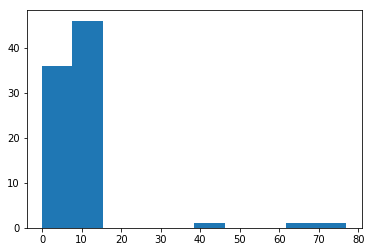

In [12]:
plt.hist(data_explore_result_nan['null'])

In [13]:
data_explore_result_nan['null'].value_counts().to_frame().sort_index()

,null
0.000000,24
0.323264,1
0.544646,10
2.058749,1
8.247000,6
8.299737,1
10.451729,5
10.452514,1
10.518154,3
10.884842,1


According to the count table and the plot, the outlier columns are `GEBURTSJAHR`(44%), `KK_KUNDENTYP`(65.6%), `AGER_TYP`(77%)

`3` Remove the outlier columns from the dataset. (You'll perform other data engineering tasks such as re-encoding and imputation later.)

In [14]:
azdias_nan.drop(['GEBURTSJAHR', 'KK_KUNDENTYP', 'AGER_TYP'], axis = 1, inplace=True)

In [15]:
azdias_nan.shape

(891221, 82)

#### Discussion 1.1.2: Assess Missing Data in Each Column<a class="anchor" id="#4-discussion1-1-2"></a>
Back to [TOC](#toc)

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

`Answer:` 
1. Most columns have less than 15% of missing values. Only three columns were removed from the dataset since they have higher percentage of missing values. According to the count table and the plot, the outlier columns are `GEBURTSJAHR`(44%), `KK_KUNDENTYP`(65.6%), `AGER_TYP`(77%).
2. For columns with the same type of information (e.g., column names with same prefix), they share the same percentage of missing data. For example, column names start with `LP` or `CAMEO`. It means sense since these variables are likely from the same question in the questionnaire.

#### Step 1.1.3: Assess Missing Data in Each Row<a class="anchor" id="#4-step1-1-3"></a>
Back to [TOC](#toc)

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

`1` How much data is missing in each row of the dataset?

> `Notes` I would like to summarize a table with one column is the percentage of data that is missing in the row(`missing_percentage`), another column is the percentage of rows that has equal or higher percentage of missing data in the row(`missing_percent_count_cumsum`).

In [16]:
def missing_percent_row(df):
    row_null = df.isnull().sum(axis=1)/df.shape[1] * 100
    return row_null.to_frame('missing_percent')

In [17]:
df_missing_percent_row = missing_percent_row(azdias_nan)['missing_percent'].value_counts().to_frame()
df_missing_percent_row['missing_percentage'] = df_missing_percent_row.index
df_missing_percent_row.reset_index(inplace=True)
df_missing_percent_row.sort_values('missing_percentage', ascending=False, inplace=True)

In [18]:
df_missing_percent_row['missing_percent_count_cumsum'] = df_missing_percent_row['missing_percent'].cumsum() \
                                                        /sum(df_missing_percent_row['missing_percent'])

In [19]:
df_missing_percent_row

,index,missing_percent,missing_percentage,missing_percent_count_cumsum
43,59.756098,2,59.756098,0.000002
44,58.536585,1,58.536585,0.000003
1,56.097561,73499,56.097561,0.082473
34,54.878049,29,54.878049,0.082506
30,53.658537,68,53.658537,0.082582
39,48.780488,8,48.780488,0.082591
21,47.560976,574,47.560976,0.083235
26,46.341463,354,46.341463,0.083632
36,45.121951,26,45.121951,0.083662
28,43.902439,118,43.902439,0.083794


`Notes`: Based on the table `df_missing_percent_row` above, around 20.5% of the rows have missing values more than 4.87%.

`2` Divite the data into two subsets using threshold 5%

In [20]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
filter_low_nan_row = missing_percent_row(azdias_nan)['missing_percent'] <= 5

In [21]:
azdias_low_nan = azdias_nan[filter_low_nan_row]
azdias_high_nan = azdias_nan[~filter_low_nan_row]

In [22]:
azdias_low_nan.shape

(725046, 82)

In [23]:
azdias_high_nan.shape

(166175, 82)

`3` Choose five columns where there are no or few missing values in the two subsets

> `Notes` 
- I first use `data_explore` function to find out the missing percentage for each column in both dataset. 
- I then join the `data_explore` function results of two datasets together as a dataframe `df_low_high_result`. 
- I created a new column `sum` in the `df_low_high_result` table, which is the sum of the missing percentage in the same columns for both data sets.
- I used the criteria of `sum` <= 5 to get a list of columns that have no or low missing percentage in both subsets.

In [24]:
dt_explore_result_low_nan = data_explore(azdias_low_nan)

1. The shape of the data is (725046, 82)


In [25]:
dt_explore_result_high_nan = data_explore(azdias_high_nan)

1. The shape of the data is (166175, 82)


In [26]:
# Find columns that have less missing values for both datasets
df_low_high_result = dt_explore_result_low_nan.merge(dt_explore_result_high_nan, left_index=True,\
                                                    right_index=True)

In [27]:
df_low_high_result['sum'] = df_low_high_result['null_x'] + df_low_high_result['null_y']

In [28]:
df_low_high_result = df_low_high_result[df_low_high_result['sum'] <= 5]

In [29]:
# colnames is a list of column names with less missing values
colnames = df_low_high_result.index

In [30]:
colnames

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ZABEOTYP',
       'ONLINE_AFFINITAET'],
      dtype='object')

`4` Compare the distribution of values for at least five columns where there are no or few missing values, between the two subsets.

In [31]:
def count_plot_compare(df1, df2, col):
    fig = plt.figure()
    fig.add_subplot(1,2,1)
    sns.countplot(df1[col])
    fig.add_subplot(1,2,2)
    sns.countplot(df2[col])
    plt.tight_layout()

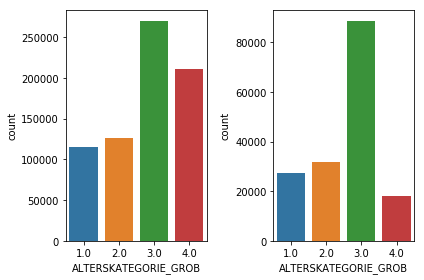

In [32]:
count_plot_compare(azdias_low_nan, azdias_high_nan, colnames[0])

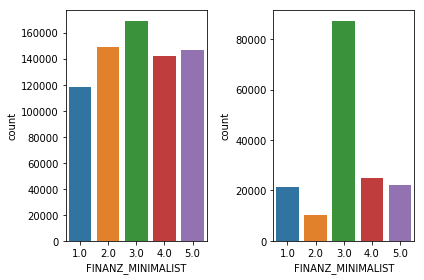

In [33]:
count_plot_compare(azdias_low_nan, azdias_high_nan, colnames[3])

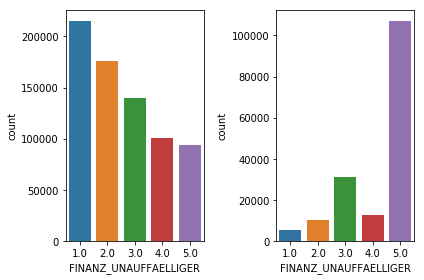

In [34]:
count_plot_compare(azdias_low_nan, azdias_high_nan, colnames[7])

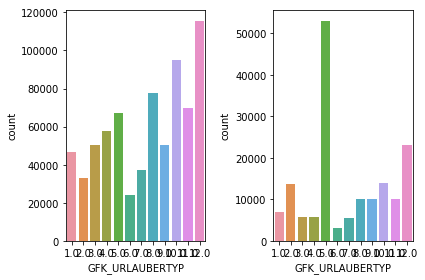

In [35]:
count_plot_compare(azdias_low_nan, azdias_high_nan, colnames[10])

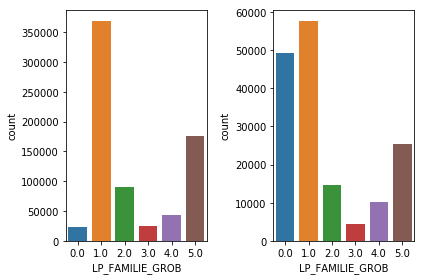

In [36]:
count_plot_compare(azdias_low_nan, azdias_high_nan, colnames[15])

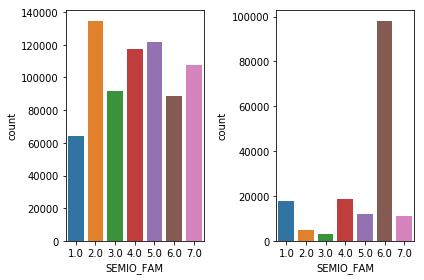

In [37]:
count_plot_compare(azdias_low_nan, azdias_high_nan, colnames[20])

#### Discussion 1.1.3: Assess Missing Data in Each Row<a class="anchor" id="4-discussion1-1-3"></a>
Back to [TOC](#toc)

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

`Answer:`
I randomly picked 5 columns with few missing data in both data sets (low_nan and high_nan), and compared the two distributions. From the visualization shown above, the data with many missing values looks very different from the data with few ro no missing values. Simply dropping these values from the analysis will cause some information lost.

### Step 1.2: Select and Re-Encode Features<a class="anchor" id="3-step1-2"></a>
Back to [TOC](#toc)

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

`1` How many features are there of each data type?

In [38]:
feat_info['type'].value_counts().to_frame()

,type
ordinal,49
categorical,21
numeric,7
mixed,7
interval,1


#### Step 1.2.1: Re-Encode Categorical Features<a class="anchor" id="4-step1-2-1"></a>
Back to [TOC](#toc)

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

`1` Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?

* Based on analysis below, there are 5 columns are binary: `ANREDE_KZ`, `OST_WEST_KZ`, `VERS_TYP`, `SOHO_KZ`, `GREEN_AVANTGARDE`.
* `OST_WEST_KZ` is binary variable but takes on non-numeric values. So it needs to be re-encoded.
* Other columns (`CJT_GESAMTTYP`, `FINANZTYP`, `GFK_URLAUBERTYP`, `LP_FAMILIE_FEIN`, `LP_FAMILIE_GROB`,`LP_STATUS_FEIN`, `LP_STATUS_GROB`, `NATIONALITAET_KZ`, `SHOPPER_TYP`,`TITEL_KZ`, `ZABEOTYP`, `GEBAEUDETYP`, `CAMEO_DEUG_2015`, `CAMEO_DEU_2015`) are multi-level.

In [39]:
filter_categorical = (feat_info['type'] == 'categorical') & (~feat_info['attribute']\
                                                             .isin(['GEBURTSJAHR', 'KK_KUNDENTYP', 'AGER_TYP']))
categorical_attribute = feat_info['attribute'][filter_categorical].tolist()

In [40]:
# Look at the unique values in each column
dt_explore_result_low_nan.filter(items=categorical_attribute, axis=0).sort_values('nunique')

,nunique,null,nsingle
ANREDE_KZ,2,0.000000,0
OST_WEST_KZ,2,0.000000,0
VERS_TYP,2,2.186620,0
SOHO_KZ,2,0.000000,0
GREEN_AVANTGARDE,2,0.000000,0
NATIONALITAET_KZ,3,1.849676,0
SHOPPER_TYP,4,2.186620,0
LP_STATUS_GROB,5,0.000000,0
LP_FAMILIE_GROB,6,0.000000,0
TITEL_KZ,6,0.000000,0


In [41]:
filter_binary = dt_explore_result_low_nan['nunique'] == 2
binary_attribute = dt_explore_result_low_nan[filter_binary]\
                    .filter(items=categorical_attribute, axis=0).index.tolist()
binary_attribute

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [42]:
multilevel_attribute = dt_explore_result_low_nan[~filter_binary]\
                .filter(items=categorical_attribute, axis=0).index.tolist()

In [43]:
# Find out which variable takes non-numeric value
for col in ['ANREDE_KZ', 'OST_WEST_KZ', 'VERS_TYP', 'SOHO_KZ', 'GREEN_AVANTGARDE']:
    print(azdias_low_nan[col].value_counts())

2.0    374378
1.0    350668
Name: ANREDE_KZ, dtype: int64
W    569025
O    156021
Name: OST_WEST_KZ, dtype: int64
2.0    375226
1.0    333966
Name: VERS_TYP, dtype: int64
0.0    718965
1.0      6081
Name: SOHO_KZ, dtype: int64
0.0    561839
1.0    163207
Name: GREEN_AVANTGARDE, dtype: int64


`2.` Re-encode categorical variable(s) to be kept in the analysis.

`2.1` Impute NAs before re-encoding

> `Notes:` `impute_na` is a function that will replace the missing value as the most frequent class for multi-level attributes. [Reference](https://dsnd-udacity.slack.com/archives/CB1E8LL5V/p1533647864000191?thread_ts=1533645515.000386&cid=CB1E8LL5V)

In [44]:
def impute_na(df, variable):
    # find most frequent category
    most_frequent_category = df.groupby([variable])[variable].count().sort_values(ascending=False).index[0]
    # replace NA
    df[variable].fillna(most_frequent_category, inplace=True)

In [45]:
# Impute all the categorical variables
for col in categorical_attribute:
    impute_na(azdias_low_nan, col)

`2.2` Re-encode OST_WEST_KZ:

In [46]:
map_dic = {'W':0, 'O':1}
azdias_low_nan['OST_WEST_KZ'].replace(map_dic, inplace=True)
azdias_low_nan['OST_WEST_KZ'].value_counts()

0    569025
1    156021
Name: OST_WEST_KZ, dtype: int64

`2.3` Re-encode multi-level variables

> `Notes:` I chose Pandas `get_dummies` function to re-encode multi-level variables since the function can take both character and numberic input. The output for column names is also very informative.

In [47]:
azdias_low_nan_categorical = azdias_low_nan.copy().reset_index().drop('index', axis=1)

In [48]:
multilevel_attribute

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'TITEL_KZ',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [49]:
for col in multilevel_attribute:
    dfDummies = pd.get_dummies(azdias_low_nan_categorical[col], prefix = (col + '_'))
    azdias_low_nan_categorical = pd.concat([azdias_low_nan_categorical, dfDummies], axis=1)

In [50]:
azdias_low_nan_categorical.shape

(725046, 218)

#### Discussion 1.2.1: Re-Encode Categorical Features<a class="anchor" id="4-discussion1-2-1"></a>
Back to [TOC](#toc)

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

`Answer:`

There are two groups in categorical features: binary and multilevel. Before re-encoding any features, I first imputed the NAs in the categorical features to the most frequent class for that feature. For the binary variables, I re-encoded the variable `OST_WEST_KZ` from string to number since ML models only accept numeric inputs.

For multi-level variables, I used pandas `get_dummies` function to re-encode these variables into dummy variables.

In this step, I didn't drop any variables since the data for these variables is very complete. I will use other feature reduction techniques in this project.

#### Step 1.2.2: Engineer Mixed-Type Features<a class="anchor" id="4-step1-2-2"></a>
Back to [TOC](#toc)

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [51]:
azdias_low_nan_categorical_mixed = azdias_low_nan_categorical.copy()

In [52]:
filter_mixed = (feat_info['type'] == 'mixed') & (~feat_info['attribute']\
                                                             .isin(['GEBURTSJAHR', 'KK_KUNDENTYP', 'AGER_TYP']))
mixed_attribute = feat_info['attribute'][filter_mixed]
dt_explore_result_low_nan.filter(items=mixed_attribute.tolist(), axis=0).sort_values('nunique')

,nunique,null,nsingle
PLZ8_BAUMAX,5,0.000000,0
KBA05_BAUMAX,6,0.000000,0
WOHNLAGE,8,0.000000,0
LP_LEBENSPHASE_GROB,13,0.000000,0
PRAEGENDE_JUGENDJAHRE,15,1.019935,0
CAMEO_INTL_2015,21,0.444386,0
LP_LEBENSPHASE_FEIN,41,0.000000,0


`1.` Impute NAs before re-encoding

In [53]:
for col in mixed_attribute:
    impute_na(azdias_low_nan_categorical_mixed, col)

`2.` Engineer mixed variable `PRAEGENDE_JUGENDJAHRE`

Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [54]:
azdias_low_nan_categorical_mixed['PRAEGENDE_JUGENDJAHRE_mainstream'] = 0
azdias_low_nan_categorical_mixed['PRAEGENDE_JUGENDJAHRE_decade'] = 0

In [55]:
filter_pj_40 = azdias_low_nan_categorical_mixed['PRAEGENDE_JUGENDJAHRE'].isin([1,2])
filter_pj_50 = azdias_low_nan_categorical_mixed['PRAEGENDE_JUGENDJAHRE'].isin([3,4])
filter_pj_60 = azdias_low_nan_categorical_mixed['PRAEGENDE_JUGENDJAHRE'].isin([5,6,7])
filter_pj_70 = azdias_low_nan_categorical_mixed['PRAEGENDE_JUGENDJAHRE'].isin([8,9])
filter_pj_80 = azdias_low_nan_categorical_mixed['PRAEGENDE_JUGENDJAHRE'].isin([10,11,12,13])
filter_pj_90 = azdias_low_nan_categorical_mixed['PRAEGENDE_JUGENDJAHRE'].isin([14,15])

In [56]:
filter_pj_mainstream = azdias_low_nan_categorical_mixed['PRAEGENDE_JUGENDJAHRE'].isin([1, 3, 5, 8, 10, 12, 14])

In [57]:
azdias_low_nan_categorical_mixed.loc[filter_pj_40, 'PRAEGENDE_JUGENDJAHRE_decade'] = 40
azdias_low_nan_categorical_mixed.loc[filter_pj_50, 'PRAEGENDE_JUGENDJAHRE_decade'] = 50
azdias_low_nan_categorical_mixed.loc[filter_pj_60, 'PRAEGENDE_JUGENDJAHRE_decade'] = 60
azdias_low_nan_categorical_mixed.loc[filter_pj_70, 'PRAEGENDE_JUGENDJAHRE_decade'] = 70
azdias_low_nan_categorical_mixed.loc[filter_pj_80, 'PRAEGENDE_JUGENDJAHRE_decade'] = 80
azdias_low_nan_categorical_mixed.loc[filter_pj_90, 'PRAEGENDE_JUGENDJAHRE_decade'] = 90

In [58]:
azdias_low_nan_categorical_mixed.loc[filter_pj_mainstream, 'PRAEGENDE_JUGENDJAHRE_mainstream'] = 1

In [59]:
azdias_low_nan_categorical_mixed['PRAEGENDE_JUGENDJAHRE_decade'].value_counts()

90    215430
70    163536
80    138854
60    109420
50     71125
40     26681
Name: PRAEGENDE_JUGENDJAHRE_decade, dtype: int64

In [60]:
azdias_low_nan_categorical_mixed['PRAEGENDE_JUGENDJAHRE_mainstream'].value_counts()

1    561839
0    163207
Name: PRAEGENDE_JUGENDJAHRE_mainstream, dtype: int64

`3.` Engineer mixed variable `CAMEO_INTL_2015`

German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


In [61]:
azdias_low_nan_categorical_mixed['CAMEO_INTL_2015_wealth'] = (azdias_low_nan_categorical_mixed['CAMEO_INTL_2015']\
                                                              .astype(int) / 10).apply(lambda x: math.floor(x))
azdias_low_nan_categorical_mixed['CAMEO_INTL_2015_life_stage'] = azdias_low_nan_categorical_mixed['CAMEO_INTL_2015']\
                                                               .astype(int) % 10

`4.` For other mixed variables `PLZ8_BAUMAX`, `KBA05_BAUMAX`, `WOHNLAGE` they can be treated as ordinal variables for the purpose of this project. I decided to drop the two variables `LP_LEBENSPHASE_GROB` and `LP_LEBENSPHASE_FEIN` for the project since it's hard to extract consistant information from these two variables based on the variable description. They also have many levels which might cause the 'curse of dimentionality'.

#### Discussion 1.2.2: Engineer Mixed-Type Features<a class="anchor" id="4-discussion-1-2-2"></a>
Back to [TOC](#toc)

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

`Answer:`

Out of 7 mixed-type features, I engineered `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015` based on the instructions. I decided to drop the two variables `LP_LEBENSPHASE_GROB` and `LP_LEBENSPHASE_FEIN` for the project since they can't be treated as ordinal variables and it's hard to extract consistant information from these two variables based on their description. They also have many levels which might cause the 'curse of dimentionality'. I kept the rest of the features and treated them as ordinal variables.

#### Step 1.2.3: Complete Feature Selection<a class="anchor" id="4-step1-2-3"></a>
Back to [TOC](#toc)

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [62]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
features_to_drop = multilevel_attribute + ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', \
                                           'LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN']

In [63]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_low_nan_clean = azdias_low_nan_categorical_mixed.drop(features_to_drop, axis=1)

In [64]:
azdias_low_nan_clean.shape

(725046, 204)

In [65]:
azdias_low_nan_clean.info()
# Make sure there are no character variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725046 entries, 0 to 725045
Columns: 204 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_life_stage
dtypes: float64(63), int64(5), uint8(136)
memory usage: 470.2 MB


### Step 1.3: Create a Cleaning Function<a class="anchor" id="3-step1-3"></a>
Back to [TOC](#toc)

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [66]:
def missing_percent_row(df):
    row_null = df.isnull().sum(axis=1)/df.shape[1] * 100
    return row_null.to_frame('missing_percent')

def impute_na(df, variable):
    # find most frequent category
    most_frequent_category = df.groupby([variable])[variable].count().sort_values(ascending=False).index[0]
    # replace NA
    df[variable].fillna(most_frequent_category, inplace=True)

def singlevalue(my_series):
    value = len(my_series.value_counts()[my_series.value_counts() == 1])
    return value
def data_explore(data_explore):
    print ("1. The shape of the data is " + str(data_explore.shape))
    data_explore_unique = pd.DataFrame(data_explore.apply(lambda x: x.nunique(), axis = 0))
    data_explore_unique.rename(columns={0:'nunique'}, inplace=True)
    data_explore_null = pd.DataFrame(data_explore.isnull().sum()/len(data_explore)*100)
    data_explore_null.rename(columns={0:'null'}, inplace=True)
    data_explore_single = pd.DataFrame(data_explore.apply(lambda x: singlevalue(x), axis = 0))
    data_explore_single.rename(columns={0:'nsingle'}, inplace=True)
    data_explore_result = data_explore_unique.join(data_explore_null, how='outer').join(data_explore_single, how='outer')
    return data_explore_result

def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    azdias_nan = df.copy()
    for i in range(len(feat_info['attribute'])):
        colname = feat_info['attribute'][i]
        missing_value = feat_info['missing_or_unknown'][i]
        missing_value_str = missing_value[1:-1].split(',')
        filter = azdias_nan[colname].map(str).isin(missing_value_str)
        azdias_nan.loc[filter, colname] = np.NaN
    
    # remove selected columns and rows, ...
    azdias_nan.drop(['GEBURTSJAHR', 'KK_KUNDENTYP', 'AGER_TYP'], axis = 1, inplace=True)
    filter_low_nan_row = missing_percent_row(azdias_nan)['missing_percent'] <= 5
    azdias_low_nan = azdias_nan[filter_low_nan_row]

    filter_categorical = (feat_info['type'] == 'categorical') & (~feat_info['attribute']\
                                                             .isin(['GEBURTSJAHR', 'KK_KUNDENTYP', 'AGER_TYP']))
    categorical_attribute = feat_info['attribute'][filter_categorical].tolist()
    dt_explore_result_low_nan.filter(items=categorical_attribute, axis=0).sort_values('nunique')
    filter_binary = dt_explore_result_low_nan['nunique'] == 2
    binary_attribute = dt_explore_result_low_nan[filter_binary]\
                    .filter(items=categorical_attribute, axis=0).index.tolist()
    multilevel_attribute = dt_explore_result_low_nan[~filter_binary]\
                .filter(items=categorical_attribute, axis=0).index.tolist()
        
    # Imput na before re-encoding
    for col in categorical_attribute:
        impute_na(azdias_low_nan, col)
    
    # select, re-encode, and engineer column values.
    #Re-encode OST_WEST_KZ:
    map_dic = {'W':0, 'O':1}
    azdias_low_nan['OST_WEST_KZ'].replace(map_dic, inplace=True)
    #Re-encode the multilevel_attributes

  
    azdias_low_nan_categorical = azdias_low_nan.copy().reset_index().drop('index', axis=1)
    
    for col in multilevel_attribute:
        dfDummies = pd.get_dummies(azdias_low_nan_categorical[col], prefix = (col + '_'))
        azdias_low_nan_categorical = pd.concat([azdias_low_nan_categorical, dfDummies], axis=1)
    
    #print(azdias_low_nan_categorical.shape)
    
    # Engineer Mixed-Type features
    azdias_low_nan_categorical_mixed = azdias_low_nan_categorical.copy()
    filter_mixed = (feat_info['type'] == 'mixed') & (~feat_info['attribute']\
                                                             .isin(['GEBURTSJAHR', 'KK_KUNDENTYP', 'AGER_TYP']))
    mixed_attribute = feat_info['attribute'][filter_mixed]
    
    # Impute NAs before encoding
    for col in mixed_attribute:
        impute_na(azdias_low_nan_categorical_mixed, col)
    
    azdias_low_nan_categorical_mixed['PRAEGENDE_JUGENDJAHRE_mainstream'] = 0
    azdias_low_nan_categorical_mixed['PRAEGENDE_JUGENDJAHRE_decade'] = 0
    
    filter_pj_40 = azdias_low_nan_categorical_mixed['PRAEGENDE_JUGENDJAHRE'].isin([1,2])
    filter_pj_50 = azdias_low_nan_categorical_mixed['PRAEGENDE_JUGENDJAHRE'].isin([3,4])
    filter_pj_60 = azdias_low_nan_categorical_mixed['PRAEGENDE_JUGENDJAHRE'].isin([5,6,7])
    filter_pj_70 = azdias_low_nan_categorical_mixed['PRAEGENDE_JUGENDJAHRE'].isin([8,9])
    filter_pj_80 = azdias_low_nan_categorical_mixed['PRAEGENDE_JUGENDJAHRE'].isin([10,11,12,13])
    filter_pj_90 = azdias_low_nan_categorical_mixed['PRAEGENDE_JUGENDJAHRE'].isin([14,15])
    
    filter_pj_mainstream = azdias_low_nan_categorical_mixed['PRAEGENDE_JUGENDJAHRE'].isin([1, 3, 5, 8, 10, 12, 14])
    
    azdias_low_nan_categorical_mixed.loc[filter_pj_40, 'PRAEGENDE_JUGENDJAHRE_decade'] = 40
    azdias_low_nan_categorical_mixed.loc[filter_pj_50, 'PRAEGENDE_JUGENDJAHRE_decade'] = 50
    azdias_low_nan_categorical_mixed.loc[filter_pj_60, 'PRAEGENDE_JUGENDJAHRE_decade'] = 60
    azdias_low_nan_categorical_mixed.loc[filter_pj_70, 'PRAEGENDE_JUGENDJAHRE_decade'] = 70
    azdias_low_nan_categorical_mixed.loc[filter_pj_80, 'PRAEGENDE_JUGENDJAHRE_decade'] = 80
    azdias_low_nan_categorical_mixed.loc[filter_pj_90, 'PRAEGENDE_JUGENDJAHRE_decade'] = 90
    
    azdias_low_nan_categorical_mixed.loc[filter_pj_mainstream, 'PRAEGENDE_JUGENDJAHRE_mainstream'] = 1
    
    azdias_low_nan_categorical_mixed['CAMEO_INTL_2015_wealth'] = (azdias_low_nan_categorical_mixed['CAMEO_INTL_2015'].astype(int) / 10) \
                                            .apply(lambda x: math.floor(x))
    azdias_low_nan_categorical_mixed['CAMEO_INTL_2015_life_stage'] = azdias_low_nan_categorical_mixed['CAMEO_INTL_2015'].astype(int) % 10

    # Remove the columns that I don't need
    features_to_drop = multilevel_attribute + ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', \
                                           'LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN']
    azdias_low_nan_clean = azdias_low_nan_categorical_mixed.drop(features_to_drop, axis=1)

    # Return the cleaned dataframe.
    return azdias_low_nan_clean

> `Notes` Check if the function returns the same dataframe as the one generated in previous procesures

In [67]:
azdias_check = clean_data(azdias)
azdias_check.equals(azdias_low_nan_clean)

True

## Step 2: Feature Transformation<a class="anchor" id="2-step2"></a>
Back to [TOC](#toc)

### Step 2.1: Apply Feature Scaling<a class="anchor" id="3-step2-1"></a>

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

`1.` Impute the missing values

In [68]:
# check the missing values in the output dataset in previous steps
data_explore(azdias_low_nan_clean).sort_values('null', ascending=False)

1. The shape of the data is (725046, 204)


,nunique,null,nsingle
W_KEIT_KIND_HH,7,4.099464,0
HEALTH_TYP,3,2.186620,0
REGIOTYP,8,0.948216,0
KKK,5,0.948216,0
ARBEIT,6,0.502175,0
ORTSGR_KLS9,10,0.502175,0
RELAT_AB,6,0.502175,0
ANZ_HH_TITEL,20,0.427835,1
ALTERSKATEGORIE_GROB,4,0.336944,0
KBA13_ANZAHL_PKW,1261,0.090477,0


> `Notes`: Based on previous steps, I imputed the missing values for mixed and categorical features. I need to impute ordinal, numeric and interval features in this step. I choose to use the mean method since it won't have an impact in the `StandardScaler()` step.

In the customer dataset, column `GEBAEUDETYP` doesn't have a level 5.0 and `TITEL_KZ` doesn't have level as 2.0. In order to use the sklearn objects from the general demographics data, and apply their transformations to the customers data, I decided to delete these two rows to avoid confusion.

In [69]:
azdias['GEBAEUDETYP'].value_counts().to_frame()

,GEBAEUDETYP
1.0,460465
3.0,178668
8.0,152476
2.0,4935
4.0,900
6.0,628
5.0,1


In [70]:
azdias['TITEL_KZ'].value_counts().to_frame()

,TITEL_KZ
0.0,815562
1.0,1947
5.0,104
4.0,57
3.0,49
2.0,3


In [71]:
azdias_low_nan_clean.drop(['GEBAEUDETYP__5.0', 'TITEL_KZ__2.0'], axis=1, inplace=True)

In [72]:
imputer_mean = Imputer()
azdias_no_nan_clean = imputer_mean.fit_transform(azdias_low_nan_clean)

In [73]:
azdias_no_nan_clean = pd.DataFrame(azdias_no_nan_clean, columns = azdias_low_nan_clean.columns)

In [74]:
# Check if the dataset contains any missing values: result as expected
data_explore(azdias_no_nan_clean).sort_values('null', ascending=False)

1. The shape of the data is (725046, 202)


,nunique,null,nsingle
ALTERSKATEGORIE_GROB,5,0.0,0
ZABEOTYP__6.0,2,0.0,0
TITEL_KZ__0.0,2,0.0,0
TITEL_KZ__1.0,2,0.0,0
TITEL_KZ__3.0,2,0.0,0
TITEL_KZ__4.0,2,0.0,0
TITEL_KZ__5.0,2,0.0,0
ZABEOTYP__1.0,2,0.0,0
ZABEOTYP__2.0,2,0.0,0
ZABEOTYP__3.0,2,0.0,0


`2.` Apply feature scaling to the general population demographics data.

In [75]:
standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(azdias_no_nan_clean)

In [76]:
# Check if X has been transformed: result as expected
pd.DataFrame(X).describe()

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
count,7.250460e+05,7.250460e+05,7.250460e+05,7.250460e+05,7.250460e+05,7.250460e+05,7.250460e+05,7.250460e+05,7.250460e+05,7.250460e+05,...,7.250460e+05,7.250460e+05,7.250460e+05,7.250460e+05,7.250460e+05,7.250460e+05,7.250460e+05,7.250460e+05,7.250460e+05,7.250460e+05
mean,5.539922e-16,-4.534445e-17,-9.972447e-17,-3.100710e-17,6.330289e-17,-1.463135e-16,1.425699e-16,8.420132e-17,7.839974e-18,4.440953e-16,...,3.194789e-17,5.723181e-18,3.137950e-17,9.118870e-17,3.164410e-17,-1.736554e-17,-7.839974e-18,-2.610319e-16,6.022080e-17,1.460195e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.743958e+00,-1.033254e+00,-1.518151e+00,-1.129370e+00,-1.774708e+00,-1.228400e+00,-1.134840e+00,-1.570485e+00,-5.389686e-01,-1.622357e+00,...,-1.539210e-01,-1.645310e-01,-1.928947e-01,-1.814233e-01,-1.950079e-01,-8.703502e-02,-1.855396e+00,-2.271566e+00,-1.565146e+00,-1.248188e+00
25%,-7.729935e-01,-1.033254e+00,-7.846781e-01,-1.129370e+00,-1.053816e+00,-1.228400e+00,-1.134840e+00,-8.446673e-01,-5.389686e-01,-2.836359e-01,...,-1.539210e-01,-1.645310e-01,-1.928947e-01,-1.814233e-01,-1.950079e-01,-8.703502e-02,5.389686e-01,-9.065473e-01,-8.839415e-01,-1.248188e+00
50%,1.979705e-01,9.678162e-01,-5.120529e-02,-4.514427e-01,3.879660e-01,1.432159e-01,-4.078548e-01,-1.188494e-01,-5.389686e-01,-2.836359e-01,...,-1.539210e-01,-1.645310e-01,-1.928947e-01,-1.814233e-01,-1.950079e-01,-8.703502e-02,5.389686e-01,-2.240380e-01,4.784674e-01,8.895003e-02
75%,1.168934e+00,9.678162e-01,6.822675e-01,9.044113e-01,1.108857e+00,8.290237e-01,1.046115e+00,6.069685e-01,-5.389686e-01,1.055086e+00,...,-1.539210e-01,-1.645310e-01,-1.928947e-01,-1.814233e-01,-1.950079e-01,-8.703502e-02,5.389686e-01,1.140980e+00,1.159672e+00,7.575193e-01
max,1.168934e+00,9.678162e-01,1.415740e+00,1.582338e+00,1.108857e+00,1.514831e+00,1.773100e+00,1.332786e+00,1.855396e+00,1.055086e+00,...,6.496841e+00,6.077883e+00,5.184174e+00,5.511972e+00,5.127998e+00,1.148963e+01,5.389686e-01,1.140980e+00,1.159672e+00,1.426089e+00


### Discussion 2.1: Apply Feature Scaling<a class="anchor" id="3-discussion2-1"></a>
Back to [TOC](#toc)

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

`Answer:`

- First I imputed ordinal, numeric and interval variables using their mean since I will apply standard scaling to these variables later. 
- In order to perform PCA to the dataset, I need to scale the variables since the PCA algorithm will try to maximize the variance for all features. I used StandardScaler to transform the data with mean equals 0 and standard deviation equals 1.

### Step 2.2: Perform Dimensionality Reduction<a class="anchor" id="3-step2-2"></a>
Back to [TOC](#toc)

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

`1.` Apply PCA to the data.

In [77]:
# Since there are 204 variables, I choose n_compoents as 102 to explore
n_components = 102
pca = PCA(n_components)
X_pca = pca.fit_transform(X)

In [78]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(80, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    plt.savefig('scree_plot_pca.jpg')

> `Notes` Since the plot is too wide, I have to export as a jpg file to better see the results. Please refer to the scree_plot_pca.fpg file in the folder.

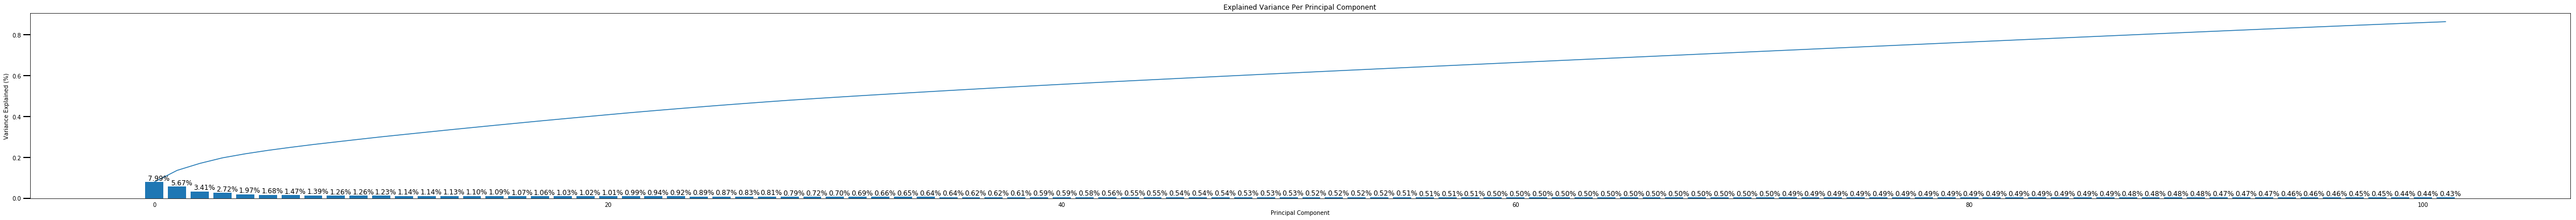

In [79]:
scree_plot(pca)

`3.` Re-apply PCA to the data while selecting for number of components to retain.

Based on the screeplot(which I saved as scree_plot_pca.jpg), I decided to choose top 9 transformed features that I'll retain for the clustering part of the project.

In [80]:
n_components = 9
pca = PCA(n_components)
X_pca = pca.fit_transform(X)

In [81]:
def scree_plot_no_save(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

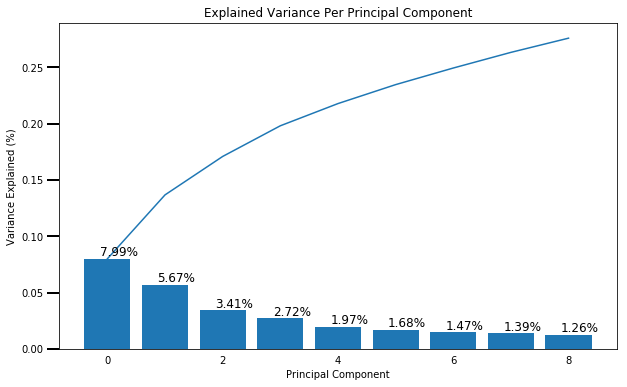

In [82]:
scree_plot_no_save(pca)

### Discussion 2.2: Perform Dimensionality Reduction<a class="anchor" id="3-discussion2-2"></a>
Back to [TOC](#toc)

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

`Answer:`

After applying PCA to 102 features, I noticed the total explained variance increased slowly after component 9, which means adding more components has less and less impact on the total variance explained in the dataset. I chose to keep top 9 transformed feature for the next step.

### Step 2.3: Interpret Principal Components<a class="anchor" id="3-step2-3"></a>
Back to [TOC](#toc)

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [83]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

In [84]:
pca_results(azdias_no_nan_clean, pca)

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,CAMEO_DEU_2015__8D,CAMEO_DEU_2015__9A,CAMEO_DEU_2015__9B,CAMEO_DEU_2015__9C,CAMEO_DEU_2015__9D,CAMEO_DEU_2015__9E,PRAEGENDE_JUGENDJAHRE_mainstream,PRAEGENDE_JUGENDJAHRE_decade,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage
Dimension 1,0.0800,-0.0796,0.0100,-0.1813,0.1045,-0.0775,0.0429,0.0471,0.1421,-0.1005,...,0.0258,0.0366,0.0563,0.0570,0.0559,0.0168,0.1005,0.0702,0.1809,-0.1071
Dimension 2,0.0568,0.2333,0.0389,0.0944,-0.2292,0.2180,-0.2051,-0.2129,0.0792,-0.0028,...,0.0338,-0.0079,0.0004,0.0050,0.0104,0.0364,0.0028,-0.2315,0.0495,0.0140
Dimension 3,0.0341,0.0183,-0.3395,0.1344,-0.0529,0.0458,-0.1538,-0.0371,-0.0707,0.0932,...,-0.0022,-0.0055,0.0099,0.0243,0.0103,-0.0020,-0.0932,-0.0504,0.0061,-0.0100
Dimension 4,0.0272,-0.0236,0.1082,-0.0041,0.0114,-0.0185,-0.0507,0.0636,-0.0299,0.2786,...,-0.0166,-0.0065,-0.0115,-0.0016,-0.0045,0.0005,-0.2786,0.0335,-0.0758,0.0369
Dimension 5,0.0197,0.0539,-0.0227,0.0457,-0.0254,0.0305,0.0316,-0.1031,-0.0329,-0.1201,...,0.0292,0.0594,0.0370,0.0187,0.0156,-0.0074,0.1201,-0.0146,0.1054,-0.0571
Dimension 6,0.0168,0.0065,0.0127,-0.0225,-0.0021,-0.0112,0.0250,-0.0149,0.0345,-0.0441,...,-0.0128,-0.0161,-0.0076,-0.0032,-0.0174,0.0364,0.0441,0.0043,-0.0161,-0.0032
Dimension 7,0.0147,-0.0070,0.0037,0.1353,-0.0001,-0.0563,0.0030,-0.0408,-0.2127,-0.0078,...,-0.0450,0.0315,0.0973,0.0925,0.0714,0.0093,0.0078,0.0341,-0.0432,-0.0853
Dimension 8,0.0139,-0.0333,-0.0039,0.0087,0.0052,0.0161,0.0085,0.0086,0.0092,0.0174,...,0.0512,-0.0026,-0.0341,-0.0509,-0.0009,-0.0719,-0.0174,-0.0239,0.0760,0.0627
Dimension 9,0.0126,0.0140,-0.0063,-0.0304,0.0131,0.0850,-0.0374,0.0750,-0.0107,-0.0249,...,-0.0839,0.0735,0.0176,0.0586,0.1044,0.0274,0.0249,-0.0138,0.0250,-0.2159


In [85]:
pca_results(azdias_no_nan_clean, pca).loc['Dimension 1',:].to_frame().sort_values('Dimension 1')

,Dimension 1
MOBI_REGIO,-0.2047
KBA05_ANTG1,-0.1905
PLZ8_ANTG1,-0.1838
KBA05_GBZ,-0.1828
FINANZ_MINIMALIST,-0.1813
PLZ8_GBZ,-0.1357
KONSUMNAEHE,-0.1355
INNENSTADT,-0.1280
LP_STATUS_FEIN__10.0,-0.1112
LP_STATUS_GROB__5.0,-0.1112


In [86]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results(azdias_no_nan_clean, pca).loc['Dimension 2',:].to_frame().sort_values('Dimension 2')

,Dimension 2
PRAEGENDE_JUGENDJAHRE_decade,-0.2315
FINANZ_SPARER,-0.2292
SEMIO_REL,-0.2173
FINANZ_UNAUFFAELLIGER,-0.2129
SEMIO_TRADV,-0.2095
SEMIO_PFLICHT,-0.2086
FINANZ_ANLEGER,-0.2051
SEMIO_RAT,-0.1688
SEMIO_KULT,-0.1669
ONLINE_AFFINITAET,-0.1602


In [87]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results(azdias_no_nan_clean, pca).loc['Dimension 3',:].to_frame().sort_values('Dimension 3')

,Dimension 3
ANREDE_KZ,-0.3395
SEMIO_KAEM,-0.3088
SEMIO_DOM,-0.2747
SEMIO_KRIT,-0.2592
SEMIO_ERL,-0.2014
FINANZ_ANLEGER,-0.1538
SEMIO_RAT,-0.1510
SHOPPER_TYP__2.0,-0.0998
FINANZTYP__1.0,-0.0984
PRAEGENDE_JUGENDJAHRE_mainstream,-0.0932


### Discussion 2.3: Interpret Principal Components<a class="anchor" id="3-discussion2-3"></a>
Back to [TOC](#toc)

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

- **Dimension 1:** The negative variables are `MOBI_REGIO`, `KBA05_ANTG1`, `PLZ8_ANTG1`. The positive variables are `LP_STATUS_GROB__1.0`, `PLZ8_ANTG3`, `CAMEO_INTL_2015_wealth`.
    - Negative variables:
        - `MOBI_REGIO` (RR1 region features): movement patterns (from high to low)
        - `KBA05_ANTG1` (RR3 microcell features): Number of 1-2 family houses in the microcell (from low to high)
        - `PLZ8_ANTG1` (PLZ8 macrocell features): Number of 1-2 family houses in the PLZ8 region (from low to high)
    - Positive variables:
        - `LP_STATUS_GROB_1.0`(person level): Social status as low income earners (Yes or No)
        - `PLZ8_ANTG3` (PLZ8 macrocell features): Number of 6-10 family houses in the PLZ8 region (from low to high)
        - `CAMEO_INTL_2015_wealth` (RR4 microcell features): wealth (from wealthy to poor)
    - Discussion:
        - The first component seems to be related to one's wealth level (represented by earning level and the neighborhood the individual is living)
        - If a group of people have high values in the negative variables, it means the group of people have stable housing (low in movement), have higher share of number of 1-2 family houses (the neighborhood is wealthier and less populated).
        - If a group of people have high values in the positive variables, it means the group of people are low income earners, poor and live in a poorer and more populated neighborhood (higher share of number of 6-10 family houses).

- **Dimension 2:** The negative variables are `PRAEGENDE_JUGENDJAHRE_decade`, `FINANZ_SPARER`, `SEMIO_REL`. The positive variables are `ALTERSKATEGORIE_GROB`, `FINANZ_VORSORGER`, `ZABEOTYP__3.0`.
    - Negative variables:
        - `PRAEGENDE_JUGENDJAHRE_decade` (person level): Dominating movement of person's youth (generation by decade)
        - `FINANZ_SPARER` (person level): financial typology - money saver (from high to low)
        - `SEMIO_REL` (person level): personality typology - religious (from highest to lowest)
    - Positive variables:
        - `ALTERSKATEGORIE_GROB`(person level): Estimated age based on given name analysis (from young to old)
        - `FINANZ_VORSORGER` (person level): financial typology - be prepared (from high to low)
        - `ZABEOTYP__3.0` (person level): Energy consumption typology - fair supplied (Yes or No)
    - Discussion:
        - The second component seems to be related to one's age (generation), level of religiousness, level of conservativeness in finanicial spending.
        - If a group of people have high values in the negative variables, it means the group of people are less conservative, younger, not a money saver and not very religious.
        - If a group of people have high values in the positive variables, it means the group of people are more conservative, older, lower prepared financially and fair supplied in energy consumption.

- **Dimension 3:** The negative variables are `ANREDE_KZ`, `SEMIO_KAEM`, `SEMIO_DOM`. The positive variables are `SEMIO_VERT`, `SEMIO_FAM`, `SEMIO_SOZ`.
    - Negative variables:
        - `ANREDE_KZ` (person level): gender (1 male, 2 female)
        - `SEMIO_KAEM` (person level): personality typology - combative attitude (from highest to lowest)
        - `SEMIO_DOM` (person level): personality typology - dominant-minded (from highest to lowest)
    - Positive variables:
        - `SEMIO_VERT`(person level): personality typology - dreamful (from highest to lowest)
        - `SEMIO_FAM` (person level): personality typology - family-minded (from highest to lowest)
        - `SEMIO_SOZ` (person level): personality typology - social-minded (from highest to lowest)
    - Discussion:
        - The third component seems to be related to one's gender and personality, such as level of combative attitude, family-oriented, social-oriented and dominant minded.
        - If a group of people have high values in the negative variables, it means the group of people are very likely to be female who are less combative, less dominant.
        - If a group of people have high values in the positive variables, it means the group of people are less dreamful, less family-minded and less social-minded.

## Step 3: Clustering<a class="anchor" id="2-step3"></a>
Back to [TOC](#toc)

### Step 3.1: Apply Clustering to General Population<a class="anchor" id="3-step3-1"></a>

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

> `Warning:` The code in next cell takes around 20 minutes to run

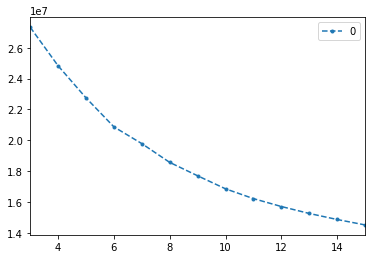

In [88]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.


score_list = []
k_list = []
for i in range(2, 15):
    kmeans = KMeans(i+1)
    model = kmeans.fit(X_pca)
    score = model.score(X_pca)
    score_list.append(abs(score))
    k_list.append(i+1)

df = pd.DataFrame(score_list, index=k_list)
df.plot(style='.--')

> `Notes:` The y axis of the graph is the score of the model, which is the average distance of each point from the center point of the cluster. The x axis is the number of clusters.Using the elbow method, I can tell that the decrease in y value gets smaller when k is around 6 or 7. Adding another cluster has less and less impact when k > 7. Based on the plot above, I choose the k equals 7.

In [89]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
number_cluster = 7
kmeans = KMeans(7)
labels = kmeans.fit_predict(X_pca)

In [90]:
# azdias_no_nan_clean['label'] = labels
# azdias_no_nan_clean.head()
df_general_pca = pd.DataFrame(X_pca, index = list(range(X_pca.shape[0])), \
                                                          columns = list(range(X_pca.shape[1])))
df_general_pca['label'] = labels
df_general_pca.head()

,0,1,2,3,4,5,6,7,8,label
0,4.803232,-3.886135,-3.213036,0.844105,0.584398,0.607258,-1.639881,-0.905944,1.655807,2
1,-0.678028,-0.834682,-3.301424,1.775312,-3.690332,-0.437279,-1.763229,0.057961,0.696235,0
2,-5.264805,1.599520,-1.332963,-1.753880,-0.377042,0.072260,2.541943,-1.839070,-0.052978,6
3,-0.210302,0.129946,3.114490,0.912492,2.776671,-1.154650,-3.924645,2.498467,-1.033540,5
4,-0.930177,-0.967635,-1.557161,-3.612555,-2.303867,-0.128539,-2.823558,1.436683,1.177810,0


### Discussion 3.1: Apply Clustering to General Population<a class="anchor" id="3-discussion3-1"></a>
Back to [TOC](#toc)

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

`Answer:`

Based on the plot generated above, the y axis of the graph is the score of the model, which is the average distance of each point from the center point of the cluster. The x axis is the number of clusters.Using the elbow method, I can tell that the decrease in y value gets smaller when k is around 6 or 7. Adding another cluster has less and less impact when k > 7. Based on the plot above, I choose the k equals 7.

### Step 3.2: Apply All Steps to the Customer Data<a class="anchor" id="3-step3-2"></a>
Back to [TOC](#toc)

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [91]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [92]:
customers.shape

(191652, 85)

`1.` Clean customer data

In [93]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)
customers_columns = customers_clean.columns

`2.` Transform customer data

In [94]:
customers_clean = imputer_mean.transform(customers_clean)

In [95]:
customers_clean = standard_scaler.transform(customers_clean)

`3.` Apply PCA to the customer data

In [96]:
customer_pca = pca.transform(customers_clean)

In [97]:
df_customer_pca = pd.DataFrame(customer_pca, index = list(range(customer_pca.shape[0])), \
                                                          columns = list(range(customer_pca.shape[1])))

`4.` Cluster the data and obtain cluster assignments for all the customer demographics data

In [98]:
customer_label = kmeans.predict(customer_pca)

In [99]:
df_customer_pca['label'] = customer_label

### Step 3.3: Compare Customer Data to Demographics Data<a class="anchor" id="3-step3-3"></a>
Back to [TOC](#toc)

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

`1.` Compare the proportion of data in each cluster for the customer data to the proportion of data in each cluster for the general population.

> `Notes:` I think the group with high missing data was qualitatively different from the main bulk of the data, so I will
treat this data as an additional data cluster.

In [100]:
general_cluster_7 = [7] * (azdias.shape[0] - len(labels))

In [101]:
labels_general = list(labels)
labels_general.extend(general_cluster_7)

In [102]:
customer_cluster_7 = [7] * (customers.shape[0] - len(customer_label))

In [103]:
customer_label = list(customer_label)
customer_label.extend(customer_cluster_7)

In [104]:
df_general_label = pd.DataFrame({'general_label':labels_general})['general_label'].value_counts().to_frame()
df_general_label['general_label'] = df_general_label['general_label']/len(labels_general)

In [105]:
df_customer_label = pd.DataFrame({'customer_label':customer_label})['customer_label'].value_counts().to_frame()
df_customer_label['customer_label'] = df_customer_label['customer_label']/len(customer_label)

In [106]:
df_gen_cus_label = df_general_label.merge(df_customer_label, how='inner', left_index=True, right_index=True)\
                    .sort_index()

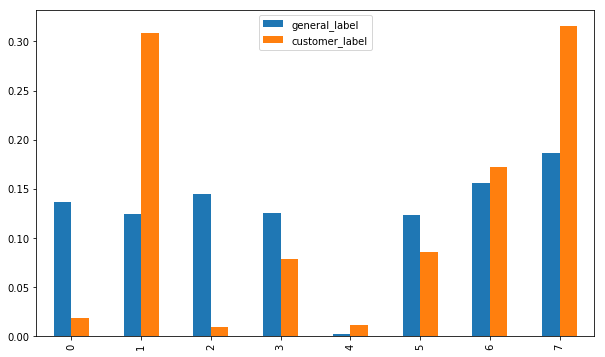

In [107]:
df_gen_cus_label.plot.bar(figsize=(10,6))

`2.` What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?

> `Notes:` Based on the plot above, cluster1 is overrepresented in the customer data compared to the general population.

In [108]:
df_customer_pca.columns = ['Component1', 'Component2', 'Component3', 'Component4', 'Component5',\
                          'Component6', 'Component7', 'Component8', 'Component9', 'label']
df_general_pca.columns = ['Component1', 'Component2', 'Component3', 'Component4', 'Component5',\
                          'Component6', 'Component7', 'Component8', 'Component9', 'label']

`2.1` Component1 in Cluster1

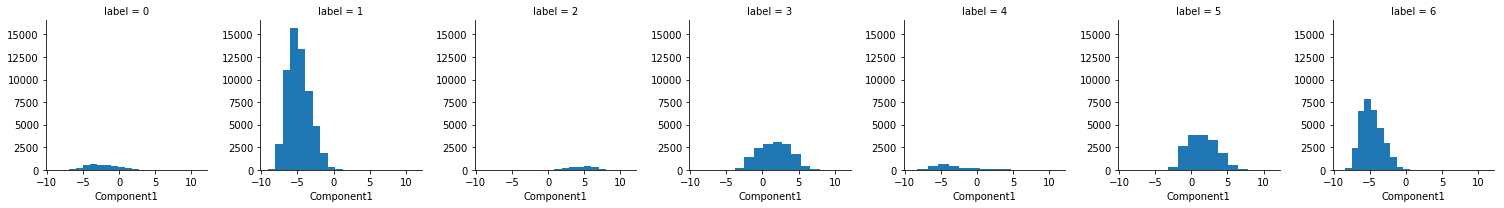

In [110]:
# Compare the distribution of first component in the customer dataset between different clusters
g = sns.FacetGrid(df_customer_pca, col="label")
g.map(plt.hist, 'Component1')

* Compare the Component1 between all the 7 clusters in customer data. Component1 is distributed towards negative values with mean around -5. Compared with other clusters, cluster1 has low value in Component1.
* Based my analysis in [discussion 2.3](#3-discussion2-3), the first component seems to be related to one's wealth level (represented by earning level and the neighborhood the individual is living). Since the value of Component1 lean towards negative value, meaning the group have high values in the negative variables such as `MOBI_REGIO`, `KBA05_ANTG1`, `PLZ8_ANTG1`. The the group of people are more likely to be wealthier, have stable housing (low in movement), have higher share of number of 1-2 family houses (the neighborhood is wealthier and less populated).

`2.2` Component2 in Cluster1

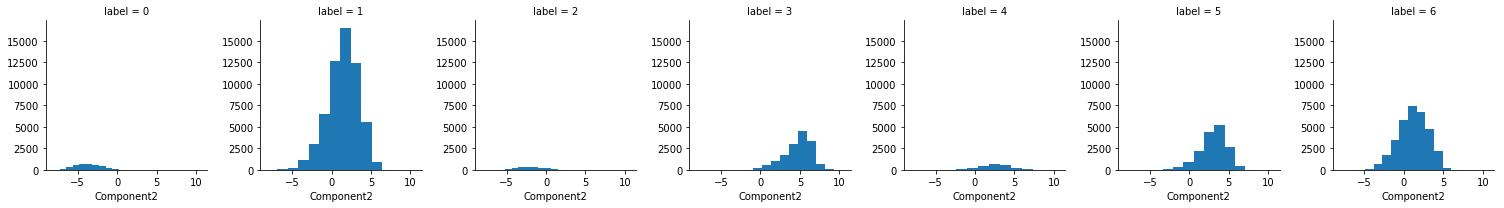

In [111]:
# Compare the distribution of second component in the customer dataset between different clusters
g = sns.FacetGrid(df_customer_pca, col="label")
g.map(plt.hist, 'Component2')

* Compare the Component2 between all the 7 clusters in customer data. Component2 is more evenly distributed around 0 but more towards positive values with mean larger than 0.
* Based my analysis in [discussion 2.3](#3-discussion2-3), the second component seems to be related to elated to one's age (generation), level of religiousness, level of conservativeness in finanicial spending. Since the value of Component2 lean towards positive value, meaning the group have relatively high values in the positive variables such as `ALTERSKATEGORIE_GROB`, `FINANZ_VORSORGER`, `ZABEOTYP__3.0`. The the group of people are more likely to be more conservative in money spending and older.

`2.3` Component3 in Cluster1

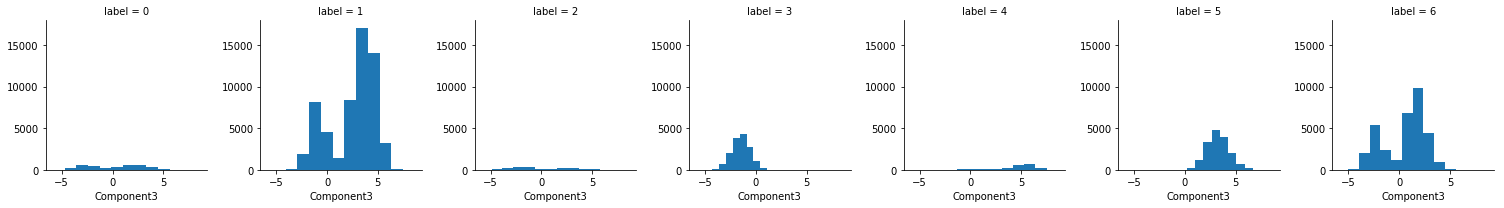

In [112]:
# Compare the distribution of third component in the customer dataset between different clusters
g = sns.FacetGrid(df_customer_pca, col="label")
g.map(plt.hist, 'Component3')

* The third component seems to be related to one's gender and personality. Based on the distribution of the third component in cluster0, we can't tell if it is significantly different from other clusters. 
* Based on distribution of Component3 in cluster1, we can tell the value leans towards positive values. It means the group of people in cluster0 are more likely to be male, less dreamful, less family-minded and less social-minded. 

`3.` What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?

> `Notes:` Based on the comparison plot above, cluster0 is underrepresented in the customer data compared to the general population.

`3.1` Component1 in Cluster0

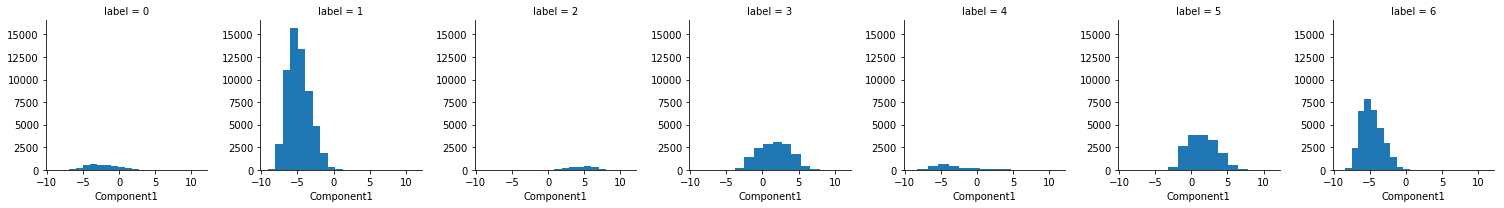

In [113]:
# Compare the distribution of the first component in the customer dataset between different clusters
g = sns.FacetGrid(df_customer_pca, col="label")
g.map(plt.hist, 'Component1')

* Compare the Component1 between all the 7 clusters in the customer data. Component1 is distributed towards positive values. Compared with other clusters, cluster1 has high value in Component1.
* Since the first component seems to be related to one's wealth level (represented by earning level and the neighborhood the individual is living). The the group of people that are underrepresented in the customer data are more likely to be low income earners, poor and live in a poorer and more populated neighborhood (higher share of number of 6-10 family houses).

`3.2` Component2 in Cluster0

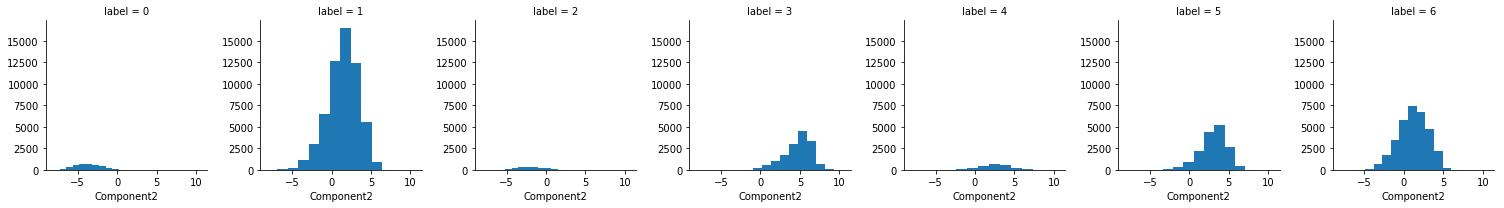

In [114]:
# Compare the distribution of the second component in the customer dataset between different clusters
g = sns.FacetGrid(df_customer_pca, col="label")
g.map(plt.hist, 'Component2')

* Compare the Component2 between all the 7 clusters in customer data. Component2 is distributed towards negative values.
* The second component seems to be related to elated to one's age (generation), level of religiousness, level of conservativeness in finanicial spending. The group of population that are underrepresented in the customer dataset are those who are less conservative, younger, not a money saver and not very religious.

`3.3` Component3 in Cluster0

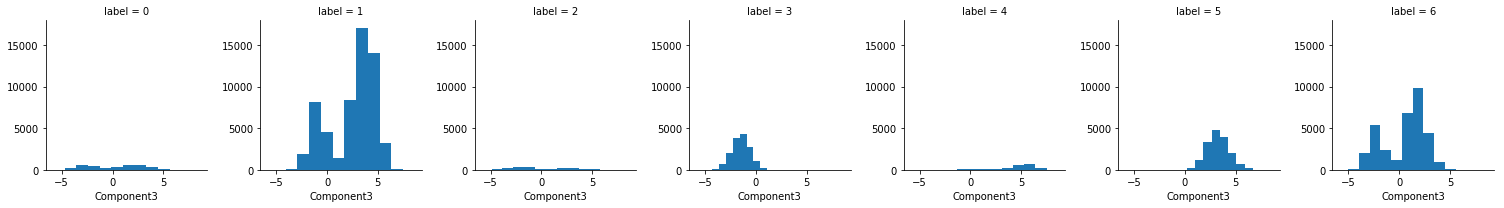

In [115]:
# Compare the distribution of the second component in the customer dataset between different clusters
g = sns.FacetGrid(df_customer_pca, col="label")
g.map(plt.hist, 'Component3')

It is hard to tell the distribution of Component3 in Cluster0 since the number of customers is relatively small. Since Component3 is related to gender and personality, I will visualize the Component3 in Cluster0 individually.

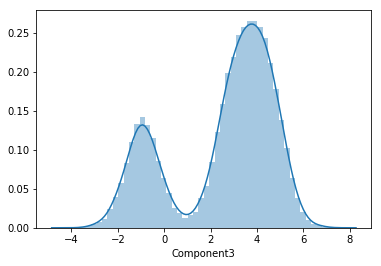

In [116]:
filter_customer_cluster1 = df_customer_pca['label'] == 1
sns.distplot(df_customer_pca.loc[filter_customer_cluster1, 'Component3'])

From the graph above, we can tell that the group of people that are underrepresented in the customer data are those with negative values in Component3 (who are very likely to be female who are less combative, less dominant.)

### Discussion 3.3: Compare Customer Data to Demographics Data<a class="anchor" id="3-discussion3-3"></a>
Back to [TOC](#toc)

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

* Based on the analysis above, the segments of the population that are relatively popular with the mail-order company are those who are:
    * wealthier, have stable housing (low in movement), live in a wealthier and less populated neighborhood
    * older, more conservative in money spending
    * male, less dreamful, less family-minded and less social-minded
* The segments of the population that are relatively unpopular with the company are those who are:
    * low income earners, poor and live in a poorer and more populated neighborhood
    * less conservative, younger, not a money saver and not very religious
    * female, less combative and less dominant